<a href="https://colab.research.google.com/github/bbeyrie/images/blob/master/Copy_of_Digimeetup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  <center> Digimeetup : Examples</center>


In [0]:
!git clone https://github.com/bbeyrie/images.git
!pip install scipy==1.1

fatal: destination path 'images' already exists and is not an empty directory.


In [0]:
import scipy
scipy.__version__

'1.1.0'

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('default')

## Example 1 : Mathematical morphology

Dilatation, Erosion, Opening, Closing

Text(0.5, -0.3, 'Ouverture')

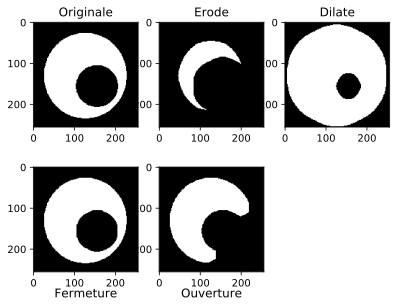

In [0]:
import cv2
morph=plt.imread('./images/morpho.jpg')
plt.subplot(2,3,1)
plt.imshow(morph)
plt.title("Originale")

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))

eroded = cv2.morphologyEx(morph, cv2.MORPH_ERODE, kernel,iterations = 10)
plt.subplot(2,3,2)
plt.imshow(eroded)
plt.title("Erode")

dilated = cv2.morphologyEx(morph, cv2.MORPH_DILATE, kernel,iterations = 10)
plt.subplot(2,3,3)
plt.imshow(dilated)
plt.title("Dilate")

closed = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel,iterations = 10)
plt.subplot(2,3,4)
plt.imshow(closed)
plt.title("Fermeture",y=-0.3)

opened = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel,iterations = 10)
plt.subplot(2,3,5)
plt.imshow(opened)
plt.title("Ouverture",y=-0.3)

4-Connexity, 8-Connexity, Region propagation ...

In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as nprand

def showImage3channels(InputImage):
  plt.figure(1)
  plt.imshow(InputImage[:,:,0],cmap='Greys')
  plt.title('channel 1: red')
  plt.colorbar()
  
  plt.figure(2)
  plt.imshow(InputImage[:,:,1],cmap='Greys')
  plt.title('channel 2: green')
  plt.colorbar()
  
  plt.figure(3)
  plt.imshow(InputImage[:,:,2],cmap='Greys')
  plt.title('channel 3: blue')
  plt.colorbar()
  
  plt.show()


def showImage1channel(InputImage,mask='Null',ColorMapForLabels=0):
  if mask=='Null':
    if ColorMapForLabels>0.5:
      imgplot = plt.imshow(InputImage,cmap='gist_ncar')
    else:
      imgplot = plt.imshow(InputImage,cmap='Greys')
    plt.colorbar()
    plt.show()
  else:
    if ColorMapForLabels>0.5:
      imgplot = plt.imshow(InputImage*(mask>0.5),cmap='gist_ncar')
    else:
      imgplot = plt.imshow(InputImage*(mask>0.5)+InputImage*(mask<0.5)*0.3,cmap='Greys')
    plt.colorbar()
    plt.show()

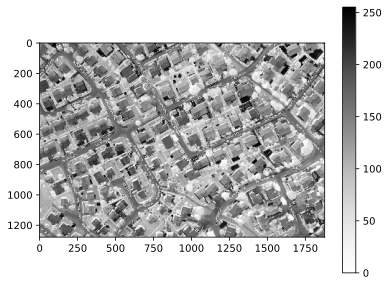

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


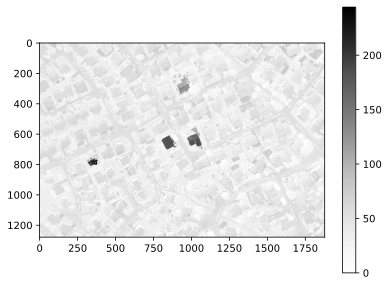

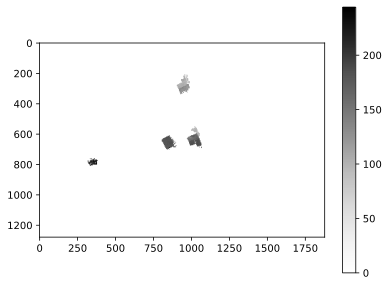

In [0]:
#Définition de la distance utilisée
def dist (Im, pt1, pt2):
    return ((Im[pt2[0],pt2[1]]-Im[pt1[0],pt1[1]])**2+math.sqrt((pt1[0]-pt2[0])**2+ (pt1[1]-pt2[1])**2))

def RegionPropagation(InputImage,seed,thresh):
    #nombre d'itérations maximal de l'algorithme
    nbMaxIter=400
    C = InputImage.copy()
    p = seed.copy()
    p_bord=p.copy()
    #Définition du champ des coûts 
    C[:,:] = thresh+1
    for x in p:     
        C[x[0],x[1]] = 0
    #nombre d'itérations de l'algorithme
    stop = 0
    # Vrai si des points ont été ajoutés à p
    changement=True
    while (changement and stop< nbMaxIter):
        changement = False
        ListNewPix = []
        #Définition d'une fonction associant à un point de l'image son coût
        def cout(y):
            return C[y[0],y[1]]
        #tri des points de p en fonction de leur cout

        for pt in p_bord:   
            for voisin_X in [-1,0,1]:
                
                for voisin_Y in [-1,0,1]:
                    vois=[pt[0]+voisin_X,pt[1]+voisin_Y]
                    if ((C[vois[0],vois[1]] > (C[pt[0],pt[1]] + dist(InputImage, vois, pt)))and not(vois in p)):
                        
                        C[vois[0],vois[1]] = (C[pt[0],pt[1]] + dist(InputImage, vois, pt))
                        ListNewPix.append(vois)
                        changement = True
       
        
        p_bord=ListNewPix.copy()
        p_bord.sort(key=cout)
        p.extend(p_bord)
        stop = stop + 1
    if (stop== nbMaxIter):
        print("Algorithme arrete apres nbMaxIter iterations, vous pouvez augmenter nbMaxIter")
    SegmentedImage = InputImage.copy()
    SegmentedImage[:,:] = 0
    for e in p:
        
        SegmentedImage[e[0],e[1]] = InputImage[e[0],e[1]]

    return SegmentedImage

Im2=(plt.imread('./images/Tournefeuille_NDG.png')*255.).astype("uint8")*1.
showImage1channel(Im2)

seed=[[650,848],[638,1017], [778,353],[289,954],[289,954]]
ImSeg=RegionPropagation(Im2,seed, 700)
showImage1channel(Im2,mask=ImSeg)
showImage1channel(ImSeg)

## Example 2 : Optimization & Image

Image denoising using the Thykonov model:

$ E(w) = \sum_{i,j=0}^{N-1} \mid \nabla w_{i,j} \mid^2 + \lambda \sum_{i,j=0}^{N-1} ( w_{i,j} - v_{i,j} )^2 $

Our image take the form of v = u + b with v our image, b a gaussian noise and u the wanted target.


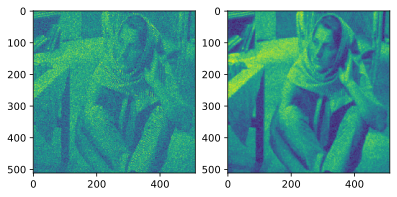

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as nprand

def grad_x(I,adjoint = False):
    x,y = np.shape(I)
    if not adjoint:      
        tmp = np.concatenate((I[1:x,:],
           I[0,:].reshape(1,-1)), axis = 0)
        out = tmp - I 
    else:
        tmp = np.concatenate((I[x-1,:].reshape(1,-1),
           I[:x-1,:]), axis = 0)
        out = tmp - I 
    return(out)   
    
def grad_y(I,adjoint = False):
    x,y = np.shape(I)
    if not adjoint:
        tmp = np.concatenate((I[:,1:y],
           I[:,0].reshape(-1,1)), axis = 1)
        out = tmp - I 
    else:
        tmp = np.concatenate((I[:,y-1].reshape(-1,1),
           I[:,:y-1]), axis = 1)
        out = tmp - I   
    return(out)
    
def direction_descente(I,out,lambdaa):
    tmp = grad_x(out,False)
    lap_x= grad_x(tmp,True)
    tmp = grad_y(out,False)
    lap_y= grad_y(tmp,True)
    descente = - (2*lap_x +2* lap_y + 2*lambdaa*(out-I))
    return(descente)    
    
def quadratique_approx(I, lambdaa = 1, nbIter = 100):
    out = I
    for i in range(nbIter):
        descente = direction_descente(I,out,lambdaa)
        out = out + 0.01 * descente
    return(out)


barbara_bruite = plt.imread('./images/barbara.bmp')
barbara_bruite = barbara_bruite[:,:,0] / 255.
barbara_bruite += nprand.normal(0,0.15,(np.shape(barbara_bruite)))
plt.subplot(1,2,1)
plt.imshow(barbara_bruite)

barbara_debruite = quadratique_approx(barbara_bruite, 1, 300)
plt.subplot(1,2,2)
plt.imshow(barbara_debruite)

Image registration using an other formula to minimize the energy

Initial energy:257761307.0


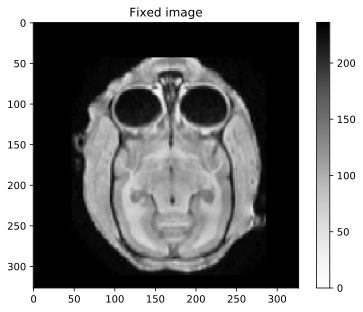

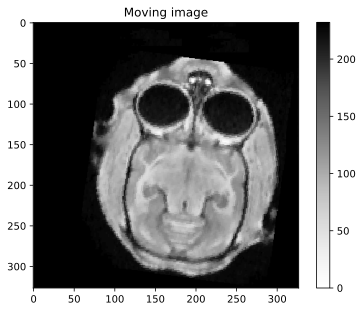

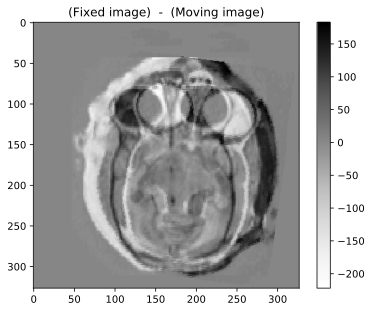

theta=-0.0085  dx=0.5  dy=0.5  -> E=265897954.0
theta=-0.013250771561535549  dx=0.6571498019566593  dy=0.9995890926840483  -> E=261414910.0
theta=-0.01825557919975677  dx=0.7585244986116781  dy=1.4931804459098055  -> E=255994848.0
theta=-0.023568053761086647  dx=0.8518569086398932  dy=1.9922172708278723  -> E=251973758.0
theta=-0.028584736047926097  dx=0.9645546155536916  dy=2.4902486412056093  -> E=247813547.0
theta=-0.03373825999063655  dx=1.0510752205839475  dy=2.997818747594207  -> E=243656243.0
theta=-0.03821366377138183  dx=1.1191531796833998  dy=3.517350386783515  -> E=238910042.0
theta=-0.04378537493174288  dx=1.1052071605115483  dy=4.044729767471558  -> E=234170869.0
theta=-0.05032668314933838  dx=1.1206715867241432  dy=4.5857304867125475  -> E=229265656.0
theta=-0.0577454869527567  dx=1.1056366656050525  dy=5.149372346121461  -> E=224412485.0
theta=-0.06731444561655836  dx=1.0297222010397833  dy=5.741664666051716  -> E=218557253.0
theta=-0.0812769065769437  dx=0.8627145282621

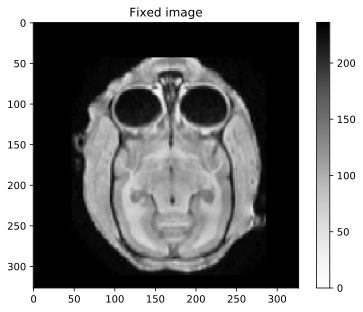

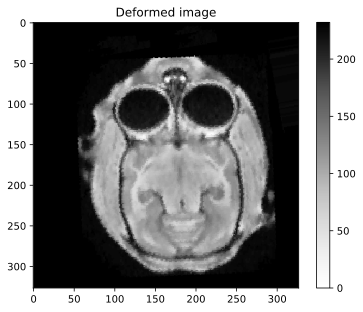

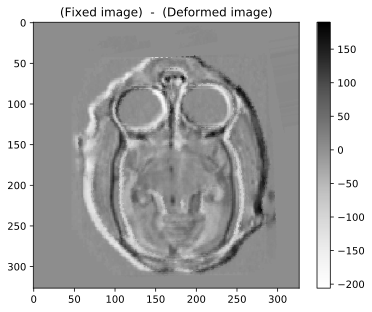

In [0]:
import numpy as np
from images import RegLib

ImFix=RegLib.OpImage('./images/Brains_Fixed.png')
ImDef=RegLib.OpImage('./images/Brains_Fixed.png')
ImMov=RegLib.OpImage('./images/Brains_Moving.png')

def CptGradE(ImFix,ImDef,ImMov,Cx,Cy,theta,Delta_theta,dx,dy,Delta_dxdy):
  """
  Approximate the gradient of E with respect to theta, dx and dy using centered finite differences.
  Inputs:
    ImFix,ImDef,ImMov: The fixed, moving and deformed images
    Cx,Cy: rotation center
    theta: rotation in radians 
    Delta_theta: Delta rotation for the finite differences
    dx,dy: translation on the x and y axes
    Delta_dxdy: Delta translation for the finite differences
  Outputs:
    dEdtheta,dEddx,dEddy: Gradient of E with respect to theta, dx and dy
  """
  #estimate the energy derivative with respect to theta
  RegLib.TranslateAndRotateImage(Cx,Cy,theta+Delta_theta,dx,dy,ImMov,ImDef)
  E_thetaPlus=RegLib.Cpt_SSD(ImDef,ImFix)
  RegLib.TranslateAndRotateImage(Cx,Cy,theta-Delta_theta,dx,dy,ImMov,ImDef)
  E_thetaMinus=RegLib.Cpt_SSD(ImDef,ImFix)
  dEdtheta=(E_thetaPlus-E_thetaMinus)/(2*Delta_theta)
  
  #estimate the energy derivative with respect to dx
  RegLib.TranslateAndRotateImage(Cx,Cy,theta,dx+Delta_dxdy,dy,ImMov,ImDef)
  E_dxPlus=RegLib.Cpt_SSD(ImDef,ImFix)
  RegLib.TranslateAndRotateImage(Cx,Cy,theta,dx-Delta_dxdy,dy,ImMov,ImDef)
  E_dxMinus=RegLib.Cpt_SSD(ImDef,ImFix)
  dEddx=(E_dxPlus-E_dxMinus)/2.
  
  #estimate the energy derivative with respect to dy
  RegLib.TranslateAndRotateImage(Cx,Cy,theta,dx,dy+Delta_dxdy,ImMov,ImDef)
  E_dyPlus=RegLib.Cpt_SSD(ImDef,ImFix)
  RegLib.TranslateAndRotateImage(Cx,Cy,theta,dx,dy-Delta_dxdy,ImMov,ImDef)
  E_dyMinus=RegLib.Cpt_SSD(ImDef,ImFix)
  dEddy=(E_dyPlus-E_dyMinus)/2.
  
  return(dEdtheta,dEddx,dEddy)


#Paramètres
theta=0.
dx=0.
dy=0.
RegLib.TranslateAndRotateImage(180,180,theta,dx,dy,ImMov,ImDef)
E_init=RegLib.Cpt_SSD(ImDef,ImFix)
print('Initial energy:'+str(E_init))
ImFix.CompareWithAnotherImage(ImMov,LabelSelfIm='Fixed image',LabelComparedIm='Moving image',ShowAll=1)



[dEdtheta,dEddx,dEddy]=CptGradE(ImFix,ImDef,ImMov,180,180,theta,0.017,dx,dy,1)
epsilon_Theta=np.fabs(0.017/dEdtheta)*0.5         #pour controler la vitesse de convergence en theta
epsilon_dx=np.fabs(1./dEddx)*0.5                  #pour controler la vitesse de convergence en dx
epsilon_dy=np.fabs(1./dEddy)*0.5                  #pour controler la vitesse de convergence en dy
for i in range(20):
    
  # Calcul du gradient d'energie   (pas de regularisation des deformations ici car on ne fait pas d'hypothese sur ce que devrait etre la deformation ideal)
  [dEdtheta,dEddx,dEddy]=CptGradE(ImFix,ImDef,ImMov,180,180,theta,0.017,dx,dy,1)
  
  # Mise a jour des parametres
  theta=theta-dEdtheta*epsilon_Theta
  dx=dx-dEddx*epsilon_dx
  dy=dy-dEddy*epsilon_dy
  
  # Affiche et sauvegarde l'evolution des parametres
  E=RegLib.Cpt_SSD(ImDef,ImFix)
  print("theta="+str(theta)+"  dx="+str(dx)+"  dy="+str(dy)+"  -> Loss="+str(E))
  RegLib.TranslateAndRotateImage(180,180,theta,dx,dy,ImMov,ImDef)

    
RegLib.TranslateAndRotateImage(180,180,theta,dx,dy,ImMov,ImDef)
print("Final parameters: theta="+str(theta)+",  dx="+str(dx)+",  dy="+str(dy))
print('Final Loss:'+str(E))

ImFix.CompareWithAnotherImage(ImDef,LabelSelfIm='Fixed image',LabelComparedIm='Deformed image',ShowAll=1)

## Example 3 : Differentials equations & Image

Texture creation using FitzHugh-Nagumo model:
 
$\delta_t u(t,x) = \Delta u(t,x) + (u(1-u)(u-\alpha)-v)/\epsilon$

$\delta_t v(t,x) = \gamma u(t,x) + \beta v(t,x)$

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
from IPython.display import clear_output

###paramètre###
a = 0.1
epsilon = 0.005
gamma = 1
beta = 0.5
N = 200;  
Nt = 1000
dx = 40/N; 
dt = 5/Nt

###Maillage###
x = np.linspace(-20,20,N)
y = np.linspace(-20,20,N)
T = np.linspace(0,5,Nt)

###Fonctions###
def f(u,v):
    #res = (np.dot(np.dot(u,(1-u)),(u-a))-v)/epsilon
    res = ((u*(1-u)*(u-a))-v)/epsilon
    return res 

def g(u,v):
    return (gamma*u) - (beta*v)

def u0(x,y):
    res = 0
    if (x>0 and y<5):
        res = 1/((1+np.exp(4*(np.linalg.norm((x,y))-5)))**2) - 1/((1+np.exp(4*(np.linalg.norm((x,y))-1)))**2)
    return res

def v0(x,y):
    res = 0
    if (x<1 and y>-10):
        res = 0.15
    return res

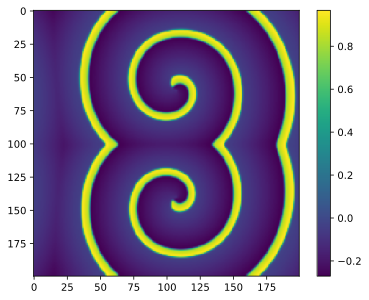

In [0]:
###Iniatialisation###
U = np.zeros((Nt,N,N))
V = np.zeros((Nt,N,N))
for i in range(N):
    for j in range(N):
        U[0,i,j] = u0(x[j],y[i])
        V[0,i,j] = v0(x[j],y[i])

#Boucle pas fractionnaire
XIx = np.fft.fftfreq(N, d = dx);
XIy = np.fft.fftfreq(N, d = dx);
Eu = np.zeros((N,N))

for o in range(N):
    for n in range(N):
        Eu[o,n] = np.exp(-((XIx[o]*2*np.pi)**2 + (XIy[n]*2*np.pi)**2) * dt); 

im = plt.imshow(U[0,:,:]); plt.colorbar(im);
                
for i in range(1,Nt):
    #equation 1
    U1 = U[i-1,:,:];
    
    #euler implicite ordre 1
    U2 = U1 + (dt) * f(U1,V[i-1,:,:]);
    #equation 2
    #on passe en base de Fourier
    U2Fourier = np.fft.fft2(U2)
    EU2Fourier = Eu * U2Fourier;
    U3 = np.real(np.fft.ifft2(EU2Fourier));
    
    #equation 3
    U3 = U3 + (dt) * f(U3,V[i-1,:,:]);
    
    #mise a jour de Un
    U[i,:,:] = U3;
    
    #mise a jour de Vn
    V[i,:,:] = V[i-1,:,:] + dt* g(U[i-1,:,:],V[i-1,:,:]);

    if (m.fmod(i,10)==0):
        clear_output(wait=True)
        im = plt.imshow(U[i,:,:]); plt.colorbar(im);
        plt.pause(0.001)

Anisotropic diffusion for image filtering :

$\delta_t I(x,y) = div(c(x,y,t) \cdot \nabla I(x,y)) $

     |████████████████████████████████| 153kB 2.8MB/s 
     |████████████████████████████████| 42.5MB 100kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp36-cp36m-linux_x86_64.whl size=753439 sha256=ebc6270ce1eb71abfd647ef8fcf918fdc23411597bd3b3f970ba75ab08a86f16
  Stored in directory: /root/.cache/pip/wheels/8c/c9/9c/2c6281c7a72b9fb1570862a4f028af7ce38405008354fbf870
Successfully built medpy


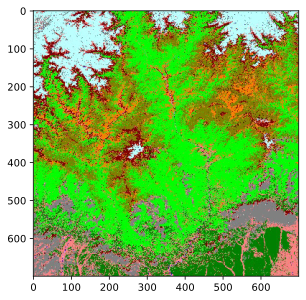

In [0]:
!pip install medpy
from  medpy.filter.smoothing import anisotropic_diffusion
Sat = plt.imread('./images/satel.jpg')
plt.imshow(Sat)

/usr/local/lib/python3.6/dist-packages/medpy/filter/smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/usr/local/lib/python3.6/dist-packages/medpy/filter/smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


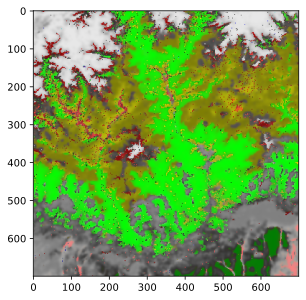

In [0]:
Sat_regul = anisotropic_diffusion(Sat,niter=50, kappa=50, gamma=0.15)
plt.imshow(Sat_regul.astype("int"))

## Example 4 : Machine Learning & Image

Clustering : Image segmentation with K-means

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as nprand
import scipy.ndimage as scim
import scipy.cluster.vq as scipyvq

def showImage3channels(InputImage):
  plt.figure(1)
  plt.imshow(InputImage[:,:,0],cmap='Greys')
  plt.title('channel 1: red')
  plt.colorbar()
  
  plt.figure(2)
  plt.imshow(InputImage[:,:,1],cmap='Greys')
  plt.title('channel 2: green')
  plt.colorbar()
  
  plt.figure(3)
  plt.imshow(InputImage[:,:,2],cmap='Greys')
  plt.title('channel 3: blue')
  plt.colorbar()
  
  plt.show()


def showImage1channel(InputImage):
  imgplot = plt.imshow(InputImage,cmap='Greys')
  plt.colorbar()
  plt.show()

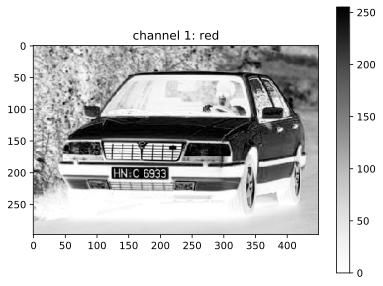

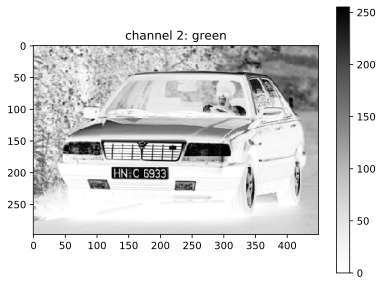

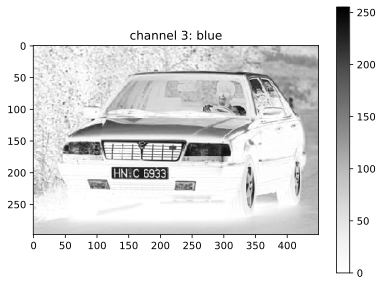

In [0]:
Im2=plt.imread('./images/voiture.jpg')
Im=Im2*1.
showImage3channels(Im)

/usr/local/lib/python3.6/dist-packages/scipy/cluster/vq.py:525: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


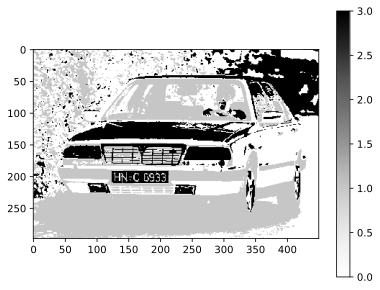

In [0]:
Imreshape=Im.reshape(Im.shape[0]*Im.shape[1],3)
c,l=scipyvq.kmeans2(Imreshape,4)

Imlabel = l.reshape(Im.shape[0],Im.shape[1])
showImage1channel(Imlabel)

Classification : Find the swimming pools with Random Forest

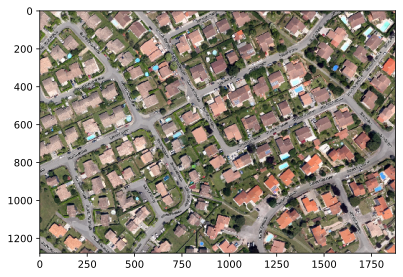

In [0]:
from sklearn.ensemble import RandomForestClassifier

Im=plt.imread('./images/Tournefeuille_RGB.png')*1.
plt.imshow(Im)

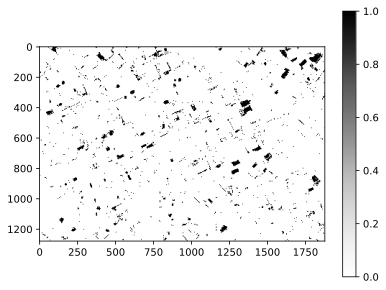

In [0]:
ImTest = np.zeros((Im.shape[0],Im.shape[1],4))
ImTest[:,:,0:3] = Im.copy()
ImTest[:,:,3] = None
Piscine = [942,1782], [868,1809], [823,1285], [767,1284], [183,1612], [257,119],[258,119],[256,119]
pasPiscine = [0,0], [1000,1000], [823,1000], [1200,1284], [183,500], [257,900],[258,0],[256,1500],[600,520],[530,700]
X=np.zeros((len(Piscine)+len(pasPiscine),3))
Y=np.zeros(len(Piscine)+len(pasPiscine))
ind = 0
for i in Piscine:
    ImTest[i[0],i[1],3] = 1
    X[ind,:] = ImTest[i[0],i[1],0:3]
    Y[ind] = 1
    ind = ind + 1
    
for i in pasPiscine:
    ImTest[i[0],i[1],3] = 0
    X[ind,:] = ImTest[i[0],i[1],0:3]
    Y[ind] = 0
    ind = ind + 1

ind = 0
Xtest = np.zeros((ImTest.shape[1]*ImTest.shape[0]-(len(Piscine)+len(pasPiscine)),3))
for i in range(0,ImTest.shape[0]):
        for j in range(0,ImTest.shape[1]):
                if (ImTest[i,j,3] != 0 and ImTest[i,j,3] != 1):
                    Xtest[ind,:] = ImTest[i,j,0:3]
                    ind = ind + 1
rf = RandomForestClassifier(n_estimators=100)
rf = rf.fit(X, Y)

Ypredict=rf.predict(Xtest)
ind = 0
for i in range(0,ImTest.shape[0]):
        for j in range(0,ImTest.shape[1]):
                if (ImTest[i,j,3] != 0 and ImTest[i,j,3] != 1):
                    ImTest[i,j,3] = Ypredict[ind]
                    ind = ind + 1
                    
                    
showImage1channel(ImTest[:,:,3])